<a href="https://colab.research.google.com/github/ritamgh/DLT-lab/blob/main/Week13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


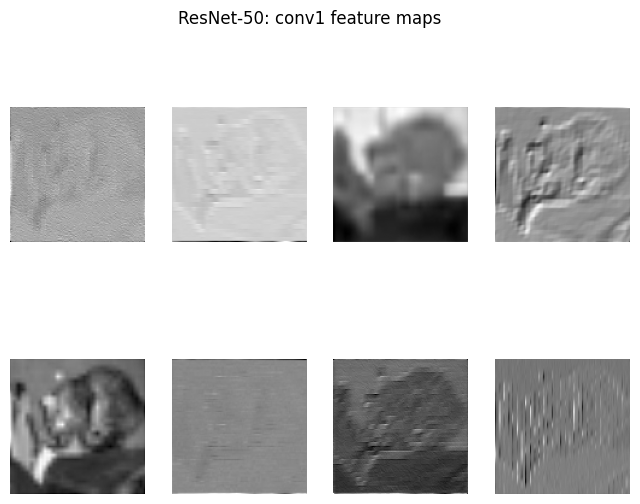

conv1        -> shape (1, 64, 112, 112)
layer1_out   -> shape (1, 256, 56, 56)
layer2_out   -> shape (1, 512, 28, 28)
layer3_out   -> shape (1, 1024, 14, 14)
layer4_out   -> shape (1, 2048, 7, 7)


In [ ]:
# =========================================
# Lab 13: Understanding Pre-trained Model (ResNet-50)
# =========================================
!pip -q install torch torchvision torchinfo ptflops

import torch, torchvision
from torchvision import models, datasets
from torchinfo import summary
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load weights & model (version-safe)
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights).to(device).eval()

# Model summary
print(summary(model, input_size=(1,3,224,224), verbose=0))

# FLOPs / Params
macs, params = get_model_complexity_info(model, (3,224,224),
                                         as_strings=True, print_per_layer_stat=False)
print("FLOPs (MACs x2 approx):", macs, "| Params:", params)

# Preprocessing (handles resize/crop/normalize)
preprocess = weights.transforms()

# Dataset (CIFAR-10 test) with the correct transforms
cifar = datasets.CIFAR10("/content/data", train=False, download=True, transform=preprocess)
img, _ = cifar[0]                 # (C,H,W) normalized tensor
x = img.unsqueeze(0).to(device)   # (1,C,H,W)

# --- Capture activations via hooks
activations = {}
def hook_factory(name):
    def hook(m, inp, out): activations[name] = out.detach().cpu()
    return hook

model.conv1.register_forward_hook(hook_factory('conv1'))
model.layer1[-1].register_forward_hook(hook_factory('layer1_out'))
model.layer2[-1].register_forward_hook(hook_factory('layer2_out'))
model.layer3[-1].register_forward_hook(hook_factory('layer3_out'))
model.layer4[-1].register_forward_hook(hook_factory('layer4_out'))

with torch.no_grad():
    _ = model(x)

# Visualize a few conv1 feature maps
fm = activations['conv1'][0]  # (C,H,W)
n_show, cols = 8, 4
rows = int(np.ceil(n_show/cols))
plt.figure(figsize=(8, 6))
for i in range(n_show):
    plt.subplot(rows, cols, i+1)
    ch = fm[i].numpy()
    ch = (ch - ch.min())/(ch.max()-ch.min() + 1e-6)
    plt.imshow(ch, cmap='gray'); plt.axis('off')
plt.suptitle("ResNet-50: conv1 feature maps")
plt.show()

for k, v in activations.items():
    print(f"{k:12s} -> shape {tuple(v.shape)}")